In [1]:
import webbpsf

In [2]:
%matplotlib inline
import pylab as pl

In [3]:
nrc = webbpsf.NIRCam()
#nrc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
nrc.filter = 'F405N'
grid = nrc.psf_grid(num_psfs=16, all_detectors=True, verbose=True, save=True)
nrc.detector = 'NRCA5'
grida = nrc.psf_grid(num_psfs=16, all_detectors=False, verbose=True)
nrc.detector = 'NRCB5'
gridb = nrc.psf_grid(num_psfs=16, all_detectors=False, verbose=True)


Running instrument: NIRCam, filter: F405N
  Running detector: NRCA5
    Position 1/16: (0, 0) pixels
    Position 1/16 centroid: (201.4203630562211, 201.72320035368165)
    Position 2/16: (0, 682) pixels
    Position 2/16 centroid: (201.523023735497, 201.6277413650047)
    Position 3/16: (0, 1365) pixels
    Position 3/16 centroid: (201.53197410885423, 201.5517164523594)
    Position 4/16: (0, 2047) pixels
    Position 4/16 centroid: (201.61835281634504, 201.55659361917634)
    Position 5/16: (682, 0) pixels
    Position 5/16 centroid: (201.4450357295695, 201.6211853968086)
    Position 6/16: (682, 682) pixels
    Position 6/16 centroid: (201.46754550370102, 201.6316619718074)
    Position 7/16: (682, 1365) pixels
    Position 7/16 centroid: (201.46166434722093, 201.58088020943816)
    Position 8/16: (682, 2047) pixels
    Position 8/16 centroid: (201.53416437469664, 201.51308620613744)
    Position 9/16: (1365, 0) pixels
    Position 9/16 centroid: (201.5163457395047, 201.52656132205

In [4]:
grid

[<photutils.psf.griddedpsfmodel.GriddedPSFModel>
 Detector: ('NRCA5', 'Detector name')
 Filter: ('F405N', 'Filter name')
 Grid_shape: (4, 4)
 Number of ePSFs: 16
 ePSF shape (oversampled pixels): (404, 404)
 Oversampling: 4,
 <photutils.psf.griddedpsfmodel.GriddedPSFModel>
 Detector: ('NRCB5', 'Detector name')
 Filter: ('F405N', 'Filter name')
 Grid_shape: (4, 4)
 Number of ePSFs: 16
 ePSF shape (oversampled pixels): (404, 404)
 Oversampling: 4]

In [5]:
nrc.detector, nrc.detector_list, nrc.detector_position

('NRCB5',
 ['NRCA1',
  'NRCA2',
  'NRCA3',
  'NRCA4',
  'NRCA5',
  'NRCB1',
  'NRCB2',
  'NRCB3',
  'NRCB4',
  'NRCB5'],
 (2047, 2047))

In [6]:
g0=grid[0]

In [7]:
g0.meta['detector']

('NRCA5', 'Detector name')

In [8]:
grids = {g.meta['detector'][0]: g for g in grid}

In [9]:
def mergegrid(x, y, size):
    """
    Get the PSF at the position relative to the bottom-left of the full field
    """

In [10]:
import stdatamodels.jwst.datamodels
from astropy.io import fits
from astropy.wcs import WCS
import glob

In [11]:
files = {'nrca': '/orange/adamginsburg/jwst/brick/F405N/pipeline/*nrca*_cal.fits',
         'nrcb': '/orange/adamginsburg/jwst/brick/F405N/pipeline/*nrcb*_cal.fits',
        }
#parent_file = stdatamodels.jwst.datamodels.open
parent_file = fits.open('/orange/adamginsburg/jwst/brick/F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-merged_i2d.fits')
parent_wcs = WCS(parent_file[1].header)

Set DATE-AVG to '2022-08-28T00:59:05.370' from MJD-AVG.
Set DATE-END to '2022-08-28T01:27:10.957' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.725189 from OBSGEO-[XYZ].
Set OBSGEO-H to 1527161940.784 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [12]:
parent_file[1].data.shape

(2334, 5691)

In [13]:
parent_wcs.pixel_to_world(0, 0)
parent_wcs.pixel_to_world(parent_file[1].data.shape[0], parent_file[1].data.shape[1])

<SkyCoord (ICRS): (ra, dec) in deg
    (266.62589108, -28.72038044)>

In [14]:
import numpy as np
from astropy.visualization import simple_norm
from tqdm.auto import tqdm

In [15]:
grids.keys()

dict_keys(['NRCA5', 'NRCB5'])

In [16]:
def footprint_contains(x, y, shape):
    return (x > 0) and (y > 0) and (y < shape[0]) and (x < shape[1])

  0%|          | 0/32 [00:00<?, ?it/s]

4


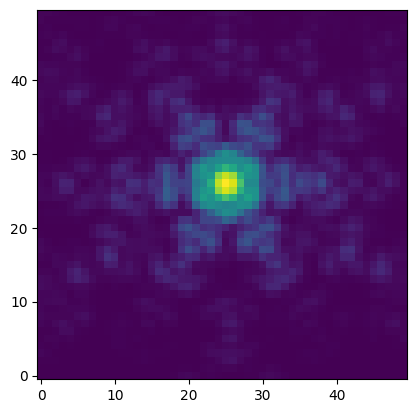

In [17]:
pixc1 = [100, 100]
skyc1 = parent_wcs.pixel_to_world(*pixc1)

psfs = []
for fn in tqdm(glob.glob('/orange/adamginsburg/jwst/brick/F466N/pipeline/*nrca*_cal.fits')):
    dmod = stdatamodels.jwst.datamodels.open(fn)
    xc, yc = dmod.meta.wcs.world_to_pixel(skyc1)
    if footprint_contains(xc, yc, dmod.data.shape):
        yy, xx = np.mgrid[int(yc)-25:int(yc)+25, int(xc)-25:int(xc)+25]
        psf = grids['NRCA5'].evaluate(x=xx, y=yy, flux=1, x_0=xc, y_0=yc)
        psfs.append(psf)
print(len(psfs))
pl.imshow(psf, origin='lower', norm=simple_norm(psf, stretch='log'))

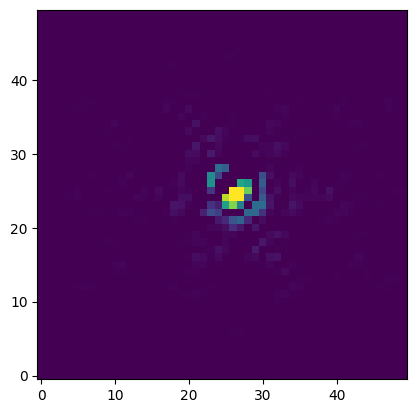

In [18]:
pl.imshow(np.array(psfs).mean(axis=0) - psfs[0], origin='lower', norm=simple_norm(psf, min_percent=1, max_percent=99, stretch='asinh'))

### Above is development, let's try for real

In [22]:
from photutils.psf import GriddedPSFModel
from astropy.nddata import NDData

In [23]:
gridfh = fits.open('nircam_nrca5_f405n_fovp101_samp4_npsf16.fits')
ndd = NDData(gridfh[0].data, meta=dict(gridfh[0].header))
ndd.meta['grid_xypos'] = [((float(ndd.meta[key].split(',')[1].split(')')[0])),
                                  (float(ndd.meta[key].split(',')[0].split('(')[1])))
                                  for key in ndd.meta.keys() if "DET_YX" in key]

ndd.meta['oversampling'] = ndd.meta["OVERSAMP"]  # just pull the value
ndd.meta = {key.lower(): ndd.meta[key] for key in ndd.meta}

model = GriddedPSFModel(ndd)
model

<photutils.psf.griddedpsfmodel.GriddedPSFModel>
Detector: NRCA5
Filter: F405N
Grid_shape: (4, 4)
Number of ePSFs: 16
ePSF shape (oversampled pixels): (404, 404)
Oversampling: 4

In [25]:
from webbpsf.utils import to_griddedpsfmodel

In [28]:
import copy

# epsf

In [33]:
import numpy as np
from photutils.psf import PSFPhotometry, IterativePSFPhotometry, SourceGrouper
from photutils.psf import EPSFBuilder, extract_stars
from photutils.detection import DAOStarFinder, IRAFStarFinder

from astropy.table import Table
from astropy.io import fits
from astropy import stats

In [34]:
filtername = 'f410m'.upper()
module = 'merged-reproject'
desat = ''
basepath = '/orange/adamginsburg/jwst/brick/'

print(f"Starting filter {filtername}", flush=True)
fwhm_tbl = Table.read(f'{basepath}/reduction/fwhm_table.ecsv')
row = fwhm_tbl[fwhm_tbl['Filter'] == filtername]
fwhm = fwhm_arcsec = float(row['PSF FWHM (arcsec)'][0])
fwhm_pix = float(row['PSF FWHM (pixel)'][0])

pupil = 'clear'
filename = f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}_i2d{desat}.fits'
fh = fits.open(filename)


im1 = fh
data = im1[1].data
err = im1['ERR'].data


filtered_errest = stats.sigma_clipped_stats(data, stdfunc='mad_std')
print(f'Error estimate for DAO from stats.: {filtered_errest}', flush=True)
filtered_errest = np.nanmedian(err)
print(f'Error estimate for DAO from median(err): {filtered_errest}', flush=True)


daofind_tuned = DAOStarFinder(threshold=5 * filtered_errest,
                              fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                              sharplo=0.30, sharphi=1.40)
print("Finding stars with daofind_tuned", flush=True)
finstars = daofind_tuned(np.nan_to_num(data))
print(len(finstars))

Starting filter F410M


2023-11-19 18:47:52,408 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


Error estimate for DAO from stats.: (11.746587250848702, 10.955075064159574, 6.481644529263514)
Error estimate for DAO from median(err): 0.15578206990446364
Finding stars with daofind_tuned
262196


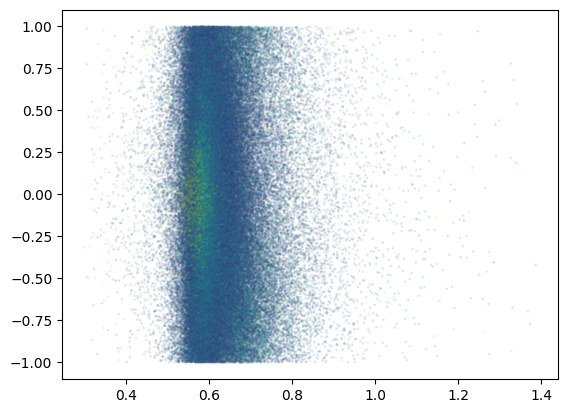

In [35]:
pl.scatter(finstars['sharpness'], finstars['roundness1'], s=1, c=finstars['peak'],
           norm=simple_norm(finstars['peak'], stretch='log', max_percent=99.95, min_percent=1),
           alpha=0.1)

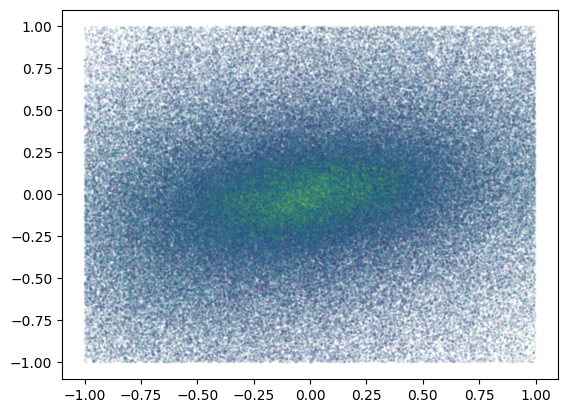

In [36]:
pl.scatter(finstars['roundness1'], finstars['roundness2'], s=1, c=finstars['peak'],
           norm=simple_norm(finstars['peak'], stretch='log', max_percent=99.95, min_percent=1),
           alpha=0.1)

In [37]:
from astropy.nddata import NDData
from astropy.visualization import simple_norm
import pylab as pl

In [38]:
daofind_tuned = DAOStarFinder(threshold=15 * filtered_errest,
                              fwhm=fwhm_pix, roundhi=0.25, roundlo=-0.25,
                              sharplo=0.40, sharphi=0.8)
finstars = daofind_tuned(np.nan_to_num(data))
finstars

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,2252.8206445598894,9.34692627742212,0.519714150536929,0.23603245246454635,0.09068151871941853,25,0.0,87.51894875292508,25.566422570385104,-3.5191749070197567
2,2259.0244626127396,14.160752284969229,0.7078632684314649,-0.05174176366185315,-0.007392180988932597,25,0.0,18.7389176258674,4.600726235294652,-1.6570659787074198
3,2220.3719121856293,16.111757074956127,0.5697372834263454,0.19342090962000358,0.22637129240257484,25,0.0,16.4405920973448,1.7781871306723027,-0.6249436569706661
4,2073.957711591077,16.222376336962487,0.5996730400372623,-0.009256145839168738,0.12457104429420991,25,0.0,18.938212476457867,2.9275323648762557,-1.1662542626141774
5,2126.246923952324,15.88743387851898,0.5662506085703111,0.07744537977427662,0.07302438403095021,25,0.0,48.98902368991175,14.005418332246105,-2.8657402135795706
6,2179.5971265337553,15.828964609863664,0.5636741069662716,0.07745756213252639,-0.04781259712201574,25,0.0,60.34961866449426,18.229628601529207,-3.1519445517869866
7,2244.0417475951467,16.941154909574518,0.6188256299998005,0.14763965048861324,0.054801828115158796,25,0.0,26.000404267084033,6.103050161884993,-1.9638673487569287
8,1846.9925564413425,20.487410474003273,0.5955405334182065,0.049301277773536684,-0.032384396301507926,25,0.0,45.55978823153772,11.560636636112163,-2.6574543775852733
9,1875.8878536087793,19.97293937500295,0.6066556028940349,0.0012064057394097917,-0.16355810006100532,25,0.0,31.29615699327909,5.740287961096222,-1.8973341982328384


Building EPSF


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

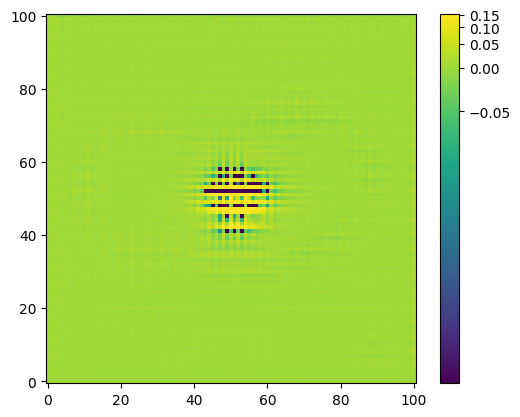

In [39]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=25)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

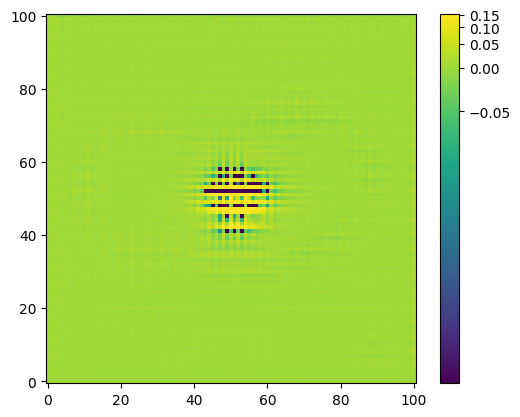

In [40]:
norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()

Building EPSF


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

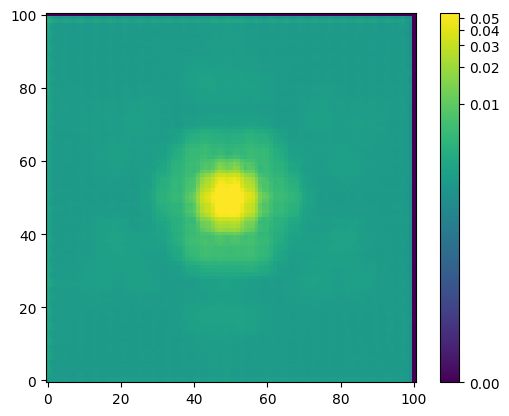

In [41]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

print(f"Using {finstars['peak'] > 100} stars")
stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=25)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

Building EPSF
nstars = 11815


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

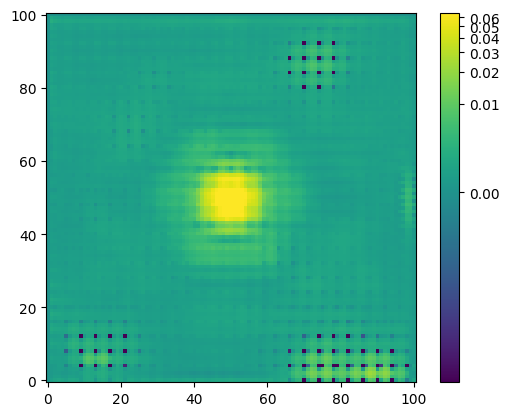

In [42]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=25)
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

In [43]:
from photutils.psf import EPSFStars

Building EPSF
nstars = 11751


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

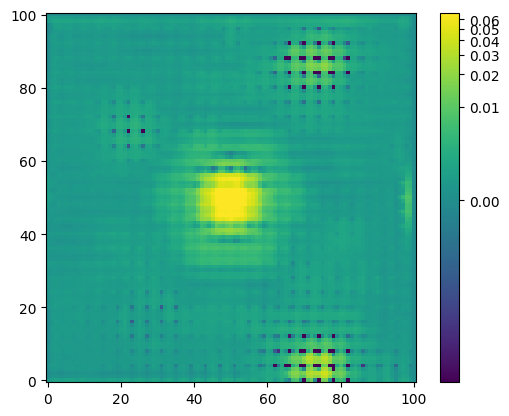

In [44]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=25)

# reject stars with negative pixels
stars = EPSFStars([x for x in stars if x.data.min() >= 0])
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

Building EPSF


2023-11-19 19:58:08,986 - stpipe - WARNING - 1 star(s) were not extracted because their cutout region extended beyond the input image.


nstars = 18336


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

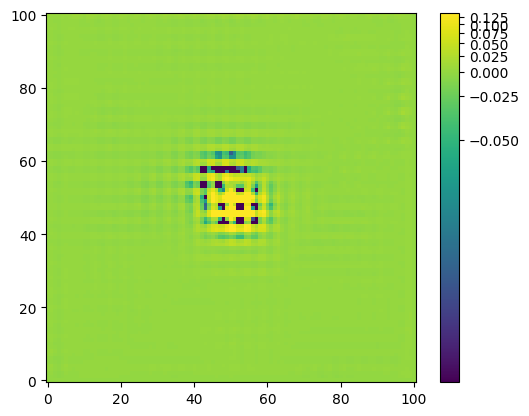

In [45]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 50], size=25)

# reject stars with negative pixels
stars = EPSFStars([x for x in stars if x.data.min() >= 0])
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

Building EPSF
nstars = 11815


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

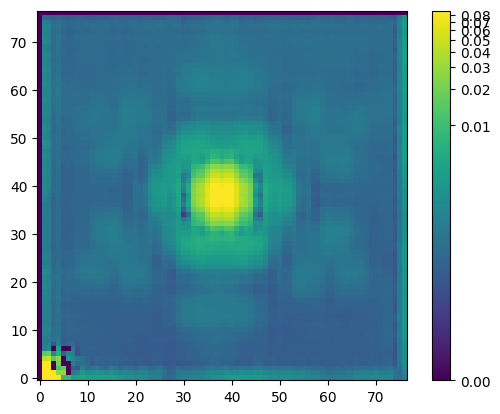

In [46]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=3, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=25)
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

# Best combination

It looks like brighter stars, with peak >200, and oversampling=4 was good enough

Building EPSF
nstars = 8280


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

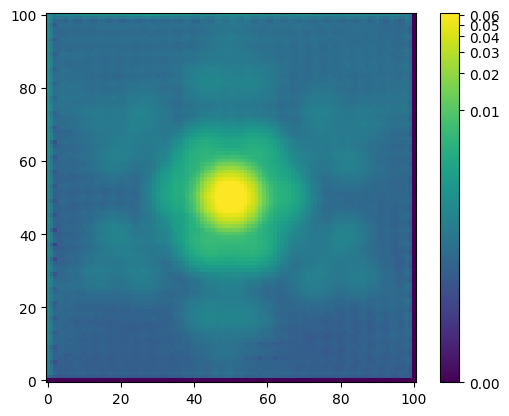

In [47]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 200], size=25)
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

In [ ]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=3, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 100], size=35)
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')

Building EPSF
nstars = 11815


EPSFBuilder (10 maxiters):   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()

In [ ]:
print("Building EPSF")
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']

epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           smoothing_kernel='quadratic',
                           progress_bar=True)

stars = extract_stars(NDData(data=np.nan_to_num(data)), finstars[finstars['peak'] > 200], size=35)
print(f'nstars = {len(stars)}')

for star in stars:
    # background subtraction
    star.data[:] -= np.nanpercentile(star.data, 5)

epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.0)
pl.figure(1).clf()
pl.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
pl.colorbar()
#pl.savefig(f'{basepath}/{filtername}/pipeline/jw02221-o001_t001_nircam_{pupil}-{filtername.lower()}-{module}{desat}{bgsub}{epsf_}_daophot_epsf.png',
#           bbox_inches='tight')